<a href="https://colab.research.google.com/github/rudra404/NLP-RNN-Emotions-Classification/blob/main/GoEmotions_RNN_experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoEmotions Experiment 2: Testing different RNN architectures and settings


In this notebook, the best performing GloVe twitter 27b pretrained vectors will be used for each experiment.
The embedding layer is frozen for all the experiments but we will unfreeze it for the best performing model to check if final accuracy goes up.

### Set up steps for notebook
---
Required packages and dependencies are installed with compatible versions and the notebook is set up to use GPU when available.

---

In [ ]:
# Install datasets
!pip install datasets

# Install dependencies
%pip install torch==1.11.0+cu113 torchdata==0.3.0 torchtext==0.12.0 -f https://download.pytorch.org/whl/cu113/torch_stable.html
%pip install spacy tqdm
!python -m spacy download en_core_web_sm

# Initialise torch and use GPU
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 9.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


Use this cell to mount your Google Drive on the notebook. Some files in the zip folder are used to reduce repeating of some setup steps.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Defining necessary functions and classes that will be used in each experiment

---
Functions for tokenizing the data and building vocabularies

---

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, vocab
from collections import OrderedDict
import torchtext.transforms as T

# defining a tokenizer as a PyTorch module
class SpacyTokenizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

    def forward(self, input):
        if isinstance(input, list):
            tokens = []
            for text in input:
                tokens.append(self.tokenizer(text))
            return tokens
        elif isinstance(input, str):
            return self.tokenizer(input)
        raise ValueError(f"Type {type(input)} is not supported.")

# defining a function to transform each text into its length
class ToLengths(torch.nn.Module):
    def forward(self, input):
        if isinstance(input[1], list):    # changed to match the order in dataset
            lengths = []
            for text in input:
                lengths.append(len(text))
            return lengths
        elif isinstance(input, list):
            return len(input)
        raise ValueError(f"Type {type(input)} is not supported.")



---


Functions required for loading data in batches


---






In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

def collate_batch(batch):
    texts, labels = zip(*batch)

    lengths = lengths_transform(list(texts))
    texts = text_transform(list(texts))
    labels = torch.tensor(list(labels), dtype=torch.int64)

    return labels.to(DEVICE), texts.to(DEVICE), lengths.cpu()


def _get_dataloader(data):
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)


---
Functions required for training and evaluation

---

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
import time

# defining a function for training the model
# Taken from lab but changed to be used for multi-class classification training instead of binary classification

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in tqdm(iterator, desc="\tTraining"):
        optimizer.zero_grad()

        labels, texts, lengths = batch  # Note that this has to match the order in collate_batch
        predictions = model(texts, lengths)
        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Defining a function to evaluate using the trained model (on either validation or test sets)
# Taken from lab 5 but changed to be used for multi-class classification evaluation instead of binary classification
# Further modified to return metrics like F1 score, confusion matrix, and classification report to check scores for each class
# ChatGPT was used for debugging aur_roc code

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    predicted_probs = []
    true_labels = []

    model.eval()

    with torch.no_grad():
        for batch in tqdm(iterator, desc="\tEvaluation"):
            labels, texts, lengths = batch  # Note that this has to match the order in collate_batch
            predictions = model(texts, lengths)
            probs = torch.softmax(predictions, dim=1)
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            predicted_probs.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predicted_probs = np.array(predicted_probs)
    true_labels = np.array(true_labels)
    predicted_labels = np.argmax(predicted_probs, axis=1)

    epoch_f1 = f1_score(true_labels, predicted_labels, average='weighted')
    epoch_auc_roc = roc_auc_score(true_labels, predicted_probs, multi_class='ovo', average='weighted')
    epoch_classification_report = classification_report(true_labels, predicted_labels)
    epoch_confusion_matrix = confusion_matrix(true_labels, predicted_labels)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1, epoch_auc_roc, epoch_classification_report, epoch_confusion_matrix


# defining a function to check duration taken for training and testing
# taken from lab 5

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


#defining a function to check number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# defining a categorical accuracy function instead of binary accuracy
# ChatGPT was used to find this piece of code and further debugging was required to make it work as expected

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


---

### Other common steps for each variation of the experiment


*   Loading and splitting preprocessed data
*   Building vocabularies
*   Pretrained embeddings
*   Preparing required dataloaders

In [ ]:
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import random_split

from torchtext.vocab import vocab
from torchtext import vocab as vc
from collections import OrderedDict

import torchtext.transforms as T

# load preprocessed data from storage
text = torch.load("/content/drive/MyDrive/Colab Notebooks/NLP CW/preprocessed_data_1.pt")
data = to_map_style_dataset(text)
data[0]

split_ratio = 0.7  # 70/30 split

# split dataset into train and test sets
train_samples = int(split_ratio * len(data))
test_samples = len(data) - train_samples
train_data, test_data = random_split(data, [train_samples, test_samples])

# split train subset into train and validation sets
train_samples = int(split_ratio * len(train_data))
valid_samples = len(train_data) - train_samples
train_data, valid_data = random_split(train_data, [train_samples, valid_samples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

# loading pretrained vectors into text_vocab
MAX_VOCAB_SIZE = 25_000

glove_vectors = vc.GloVe(
    name="twitter.27B",
    dim="100",
    max_vectors=MAX_VOCAB_SIZE
)

text_vocab = vocab(glove_vectors.stoi, min_freq=0, specials=("<unk>", "<pad>"), special_first=True)
text_vocab.set_default_index(text_vocab["<unk>"])

pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat([
    torch.empty(1, glove_vectors.dim).normal_(),  # unk token vector
    torch.zeros(1, glove_vectors.dim),  # padding token vector
    pretrained_embeddings
])

print("Pretrained vectors shape: ", pretrained_embeddings.shape)

# buidling label_vocab
label_vocab = vocab(OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)]))

# transform to required tensor format
text_transform = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    T.ToTensor(),  # Convert to tensor
)

lengths_transform = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)

# dataloaders
train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

Number of training examples: 20153
Number of validation examples: 8638
Number of testing examples: 12340


.vector_cache/glove.twitter.27B.zip: 1.52GB [04:45, 5.33MB/s]                            
100%|█████████▉| 24999/25000 [00:00<00:00, 30732.57it/s]


Pretrained vectors shape:  torch.Size([25002, 100])




---



---



---

## 2.A. RNN1

In [ ]:
import torch.nn as nn
from torch import optim

# Define a basic RNN
class RNN1(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes
PAD_IDX = text_vocab["<pad>"]

model = RNN1(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings, PAD_IDX) # create a RNN model using the arguments
print("Model Summary:")
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

Model Summary:
RNN1(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): RNN(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=14, bias=True)
)
The model has 95,246 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN1-model.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:08<00:00, 36.74it/s]


	Train Loss: 2.011 | Train Acc: 41.25%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 61.94it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.913 |  Val. Acc: 43.37%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.26it/s]


	Train Loss: 1.897 | Train Acc: 43.96%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.93it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.882 |  Val. Acc: 42.81%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.58it/s]


	Train Loss: 1.894 | Train Acc: 43.72%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.42it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.861 |  Val. Acc: 44.80%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.36it/s]


	Train Loss: 1.838 | Train Acc: 45.25%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.14it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.807 |  Val. Acc: 46.14%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.61it/s]


	Train Loss: 1.834 | Train Acc: 44.84%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.19it/s]


	 Val. Loss: 1.804 |  Val. Acc: 47.21%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.59it/s]


	Train Loss: 1.776 | Train Acc: 46.90%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.41it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.804 |  Val. Acc: 46.18%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:03<00:00, 80.26it/s]


	Train Loss: 1.831 | Train Acc: 45.56%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 84.26it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.876 |  Val. Acc: 44.37%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:03<00:00, 94.80it/s]


	Train Loss: 1.792 | Train Acc: 45.95%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.34it/s]


	 Val. Loss: 1.870 |  Val. Acc: 43.20%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.44it/s]


	Train Loss: 1.721 | Train Acc: 48.33%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.81it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.855 |  Val. Acc: 45.83%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.36it/s]


	Train Loss: 1.708 | Train Acc: 48.93%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.53it/s]


	 Val. Loss: 1.770 |  Val. Acc: 49.63%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:03<00:00, 96.34it/s] 


	Train Loss: 1.852 | Train Acc: 44.93%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.38it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.022 |  Val. Acc: 41.42%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:06<00:00, 52.47it/s]


	Train Loss: 1.904 | Train Acc: 43.85%


	Evaluation: 100%|██████████| 135/135 [00:04<00:00, 31.23it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.922 |  Val. Acc: 44.86%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.66it/s] 


	Train Loss: 1.881 | Train Acc: 44.27%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.58it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.971 |  Val. Acc: 42.24%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.94it/s]


	Train Loss: 1.852 | Train Acc: 44.76%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.21it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.896 |  Val. Acc: 45.66%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.78it/s]


	Train Loss: 1.714 | Train Acc: 48.39%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.69it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.761 |  Val. Acc: 47.80%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:03<00:00, 99.50it/s] 


	Train Loss: 1.739 | Train Acc: 47.64%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.34it/s]


	 Val. Loss: 1.793 |  Val. Acc: 47.81%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.17it/s]


	Train Loss: 1.636 | Train Acc: 50.42%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.69it/s]


	 Val. Loss: 1.757 |  Val. Acc: 48.23%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:03<00:00, 88.70it/s]


	Train Loss: 1.662 | Train Acc: 50.20%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.82it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.766 |  Val. Acc: 48.51%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.93it/s] 


	Train Loss: 1.599 | Train Acc: 51.17%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.38it/s]


	 Val. Loss: 1.736 |  Val. Acc: 49.26%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:03<00:00, 102.51it/s]


	Train Loss: 1.560 | Train Acc: 52.05%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.65it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.822 |  Val. Acc: 48.12%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:03<00:00, 102.73it/s]


	Train Loss: 1.527 | Train Acc: 52.88%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.25it/s]


	 Val. Loss: 1.799 |  Val. Acc: 49.25%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.91it/s] 


	Train Loss: 1.482 | Train Acc: 53.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.55it/s]


	 Val. Loss: 1.724 |  Val. Acc: 49.63%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.76it/s]


	Train Loss: 1.437 | Train Acc: 54.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.76it/s]


	 Val. Loss: 1.753 |  Val. Acc: 48.24%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.47it/s]


	Train Loss: 1.463 | Train Acc: 54.51%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 124.69it/s]


	 Val. Loss: 1.730 |  Val. Acc: 48.59%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.55it/s]


	Train Loss: 1.508 | Train Acc: 53.22%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 120.57it/s]


	 Val. Loss: 1.811 |  Val. Acc: 48.14%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.01it/s]


	Train Loss: 1.496 | Train Acc: 53.27%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.33it/s]


	 Val. Loss: 1.741 |  Val. Acc: 48.27%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.47it/s]


	Train Loss: 1.372 | Train Acc: 56.73%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.04it/s]


	 Val. Loss: 1.770 |  Val. Acc: 48.89%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.75it/s]


	Train Loss: 1.461 | Train Acc: 54.52%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 83.95it/s]


	 Val. Loss: 1.926 |  Val. Acc: 44.52%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:03<00:00, 85.96it/s] 


	Train Loss: 1.543 | Train Acc: 51.88%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.60it/s]


	 Val. Loss: 1.787 |  Val. Acc: 46.17%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.40it/s]


	Train Loss: 1.566 | Train Acc: 51.61%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.35it/s]


	 Val. Loss: 1.887 |  Val. Acc: 45.05%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.17it/s]


	Train Loss: 1.562 | Train Acc: 51.34%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 83.88it/s]


	 Val. Loss: 1.893 |  Val. Acc: 43.46%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.68it/s]


	Train Loss: 1.473 | Train Acc: 53.49%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.07it/s]


	 Val. Loss: 1.800 |  Val. Acc: 45.98%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.80it/s]


	Train Loss: 1.383 | Train Acc: 55.94%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 126.18it/s]


	 Val. Loss: 1.826 |  Val. Acc: 46.58%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:03<00:00, 85.87it/s]


	Train Loss: 1.334 | Train Acc: 57.20%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.00it/s]


	 Val. Loss: 1.923 |  Val. Acc: 46.18%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.94it/s] 


	Train Loss: 1.481 | Train Acc: 52.91%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.22it/s]


	 Val. Loss: 1.844 |  Val. Acc: 45.67%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.05it/s]


	Train Loss: 1.380 | Train Acc: 56.19%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.07it/s]


	 Val. Loss: 1.845 |  Val. Acc: 46.92%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.20it/s]


	Train Loss: 1.309 | Train Acc: 58.13%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.69it/s]


	 Val. Loss: 1.885 |  Val. Acc: 47.86%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:03<00:00, 83.61it/s] 


	Train Loss: 1.228 | Train Acc: 60.40%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.73it/s]


	 Val. Loss: 1.928 |  Val. Acc: 43.98%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.69it/s]


	Train Loss: 1.259 | Train Acc: 60.06%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.88it/s]


	 Val. Loss: 2.031 |  Val. Acc: 44.54%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.11it/s]


	Train Loss: 1.272 | Train Acc: 58.75%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.06it/s]


	 Val. Loss: 1.913 |  Val. Acc: 46.55%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.14it/s]


	Train Loss: 1.204 | Train Acc: 61.03%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.56it/s]


	 Val. Loss: 1.920 |  Val. Acc: 45.62%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.54it/s]


	Train Loss: 1.181 | Train Acc: 61.71%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.17it/s]


	 Val. Loss: 1.924 |  Val. Acc: 46.70%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.46it/s]


	Train Loss: 1.225 | Train Acc: 60.94%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 117.41it/s]


	 Val. Loss: 1.988 |  Val. Acc: 45.62%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.83it/s]


	Train Loss: 1.130 | Train Acc: 63.49%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 116.21it/s]


	 Val. Loss: 1.980 |  Val. Acc: 44.17%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:05<00:00, 53.33it/s] 


	Train Loss: 1.028 | Train Acc: 66.18%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.09it/s]


	 Val. Loss: 1.982 |  Val. Acc: 46.19%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:03<00:00, 85.70it/s]


	Train Loss: 0.991 | Train Acc: 67.49%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.10it/s]


	 Val. Loss: 2.037 |  Val. Acc: 47.08%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.19it/s] 


	Train Loss: 1.185 | Train Acc: 61.87%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.20it/s]


	 Val. Loss: 2.028 |  Val. Acc: 45.73%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.01it/s]


	Train Loss: 1.122 | Train Acc: 63.46%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.01it/s]


	 Val. Loss: 1.998 |  Val. Acc: 43.86%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.49it/s]


	Train Loss: 1.089 | Train Acc: 64.93%


	Evaluation: 100%|██████████| 135/135 [00:03<00:00, 44.58it/s]


	 Val. Loss: 2.000 |  Val. Acc: 44.73%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.96it/s]


	Train Loss: 1.043 | Train Acc: 65.82%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.11it/s]


	 Val. Loss: 2.033 |  Val. Acc: 43.64%


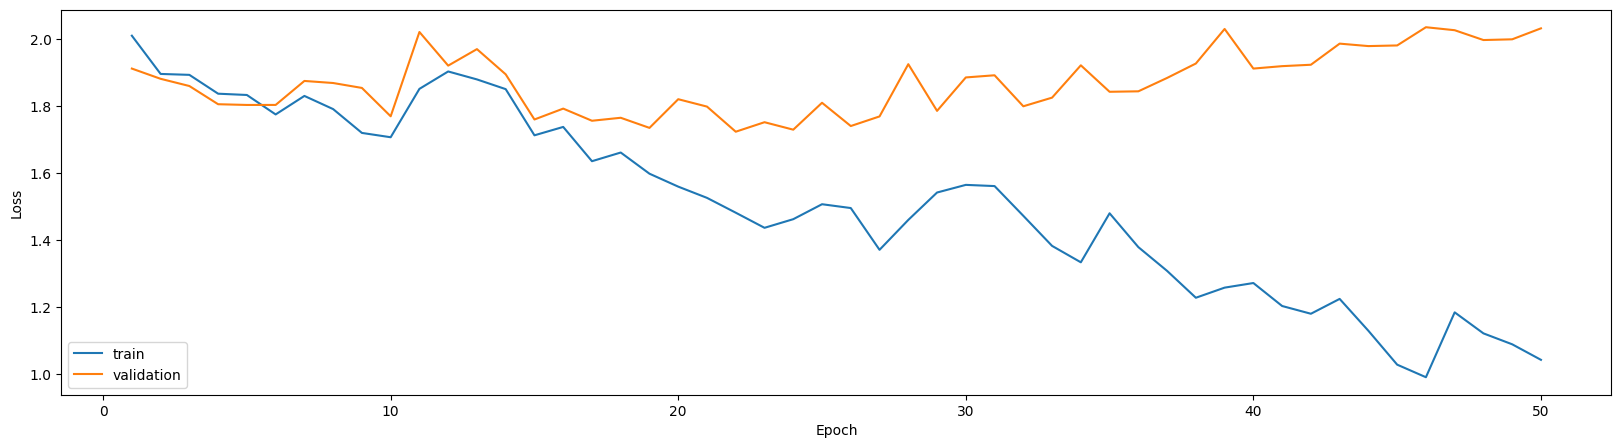

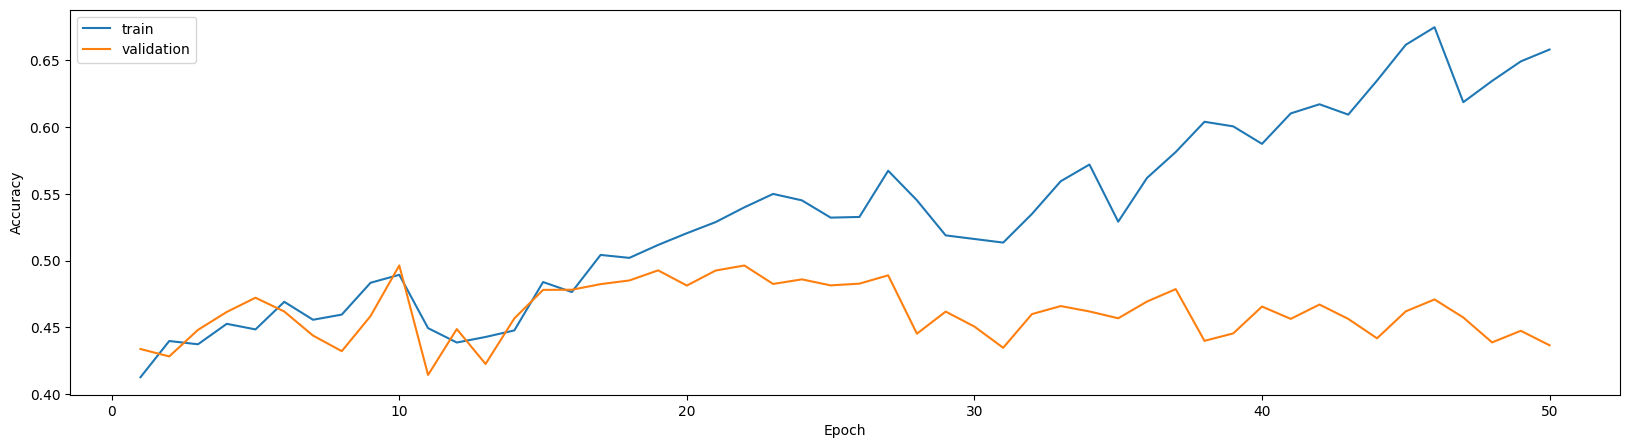

	Evaluation: 100%|██████████| 193/193 [00:02<00:00, 86.40it/s]



Test Loss: 1.712 | Test Acc: 50.22% | Test F1: 0.433 | Test ROC AUC: 0.766

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.86      0.63      4964
           1       0.48      0.50      0.49       640
           2       0.46      0.21      0.29      1070
           3       0.30      0.21      0.25       696
           4       0.20      0.02      0.03       911
           5       0.36      0.06      0.10       135
           6       0.32      0.03      0.06       329
           7       0.44      0.23      0.30       577
           8       0.00      0.00      0.00       180
           9       0.69      0.68      0.68       640
          10       0.19      0.02      0.03       573
          11       0.31      0.15      0.20       225
          12       0.72      0.57      0.64       787
          13       0.42      0.21      0.28       613

    accuracy                           0.50     12340
   macro avg       0.39      0.27 

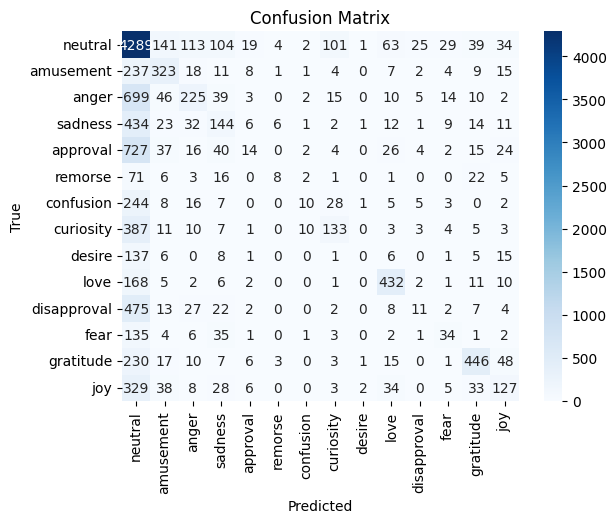

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('RNN1-model.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---

## 2.B. RNN2

In [ ]:
import torch.nn as nn
from torch import optim

# Define a bidirectional RNN
class RNN2(nn.Module):
    def __init__(self, pretrained_embeddings, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        self.rnn = nn.LSTM(pretrained_embeddings.shape[1],
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))                   # VV note that lengths need to be on the CPU
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        if self.num_directions == 2:  # if bidirectional
            # Concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers and apply dropout
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

# Setting model building arguments
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = text_vocab["<pad>"]

model = RNN2(pretrained_embeddings, HIDDEN_DIM,  OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX) # create a RNN model using the arguments
print("Model Summary:")
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters')


# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

Model Summary:
RNN2(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=14, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 2,317,326 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN2-model.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:07<00:00, 44.07it/s]


	Train Loss: 2.007 | Train Acc: 41.34%


	Evaluation: 100%|██████████| 135/135 [00:03<00:00, 34.11it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.793 |  Val. Acc: 45.91%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:05<00:00, 58.80it/s]


	Train Loss: 1.741 | Train Acc: 46.63%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 112.32it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.612 |  Val. Acc: 49.35%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:06<00:00, 47.24it/s]


	Train Loss: 1.633 | Train Acc: 49.44%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 97.27it/s] 
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.503 |  Val. Acc: 53.19%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.30it/s]


	Train Loss: 1.552 | Train Acc: 51.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 110.65it/s]


	 Val. Loss: 1.460 |  Val. Acc: 54.99%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:06<00:00, 48.17it/s]


	Train Loss: 1.507 | Train Acc: 52.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 83.97it/s] 


	 Val. Loss: 1.417 |  Val. Acc: 56.43%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:05<00:00, 61.71it/s]


	Train Loss: 1.461 | Train Acc: 54.25%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 111.66it/s]


	 Val. Loss: 1.387 |  Val. Acc: 57.03%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:06<00:00, 49.14it/s]


	Train Loss: 1.435 | Train Acc: 55.03%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 77.45it/s]


	 Val. Loss: 1.380 |  Val. Acc: 56.81%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:05<00:00, 61.69it/s]


	Train Loss: 1.400 | Train Acc: 56.16%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 109.79it/s]


	 Val. Loss: 1.371 |  Val. Acc: 57.27%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:06<00:00, 50.54it/s]


	Train Loss: 1.370 | Train Acc: 57.05%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 70.20it/s]


	 Val. Loss: 1.385 |  Val. Acc: 56.78%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.11it/s]


	Train Loss: 1.347 | Train Acc: 57.46%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 113.48it/s]


	 Val. Loss: 1.363 |  Val. Acc: 57.41%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:06<00:00, 47.35it/s]


	Train Loss: 1.318 | Train Acc: 58.32%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 69.43it/s]


	 Val. Loss: 1.361 |  Val. Acc: 57.49%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:05<00:00, 55.39it/s]


	Train Loss: 1.299 | Train Acc: 58.44%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 111.22it/s]


	 Val. Loss: 1.354 |  Val. Acc: 57.81%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:06<00:00, 50.67it/s]


	Train Loss: 1.271 | Train Acc: 59.65%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 70.43it/s]


	 Val. Loss: 1.371 |  Val. Acc: 57.40%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:05<00:00, 61.41it/s]


	Train Loss: 1.242 | Train Acc: 60.29%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 109.62it/s]


	 Val. Loss: 1.374 |  Val. Acc: 57.18%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:05<00:00, 53.71it/s]


	Train Loss: 1.217 | Train Acc: 60.87%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 71.39it/s]


	 Val. Loss: 1.380 |  Val. Acc: 57.53%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.55it/s]


	Train Loss: 1.189 | Train Acc: 61.63%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 112.64it/s]


	 Val. Loss: 1.376 |  Val. Acc: 57.76%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:05<00:00, 56.35it/s]


	Train Loss: 1.167 | Train Acc: 62.41%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 72.31it/s]


	 Val. Loss: 1.390 |  Val. Acc: 57.56%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:05<00:00, 55.69it/s]


	Train Loss: 1.136 | Train Acc: 63.01%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 115.42it/s]


	 Val. Loss: 1.404 |  Val. Acc: 57.52%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.18it/s]


	Train Loss: 1.114 | Train Acc: 63.58%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 50.14it/s]


	 Val. Loss: 1.418 |  Val. Acc: 56.90%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:06<00:00, 50.08it/s]


	Train Loss: 1.088 | Train Acc: 64.82%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 115.19it/s]


	 Val. Loss: 1.463 |  Val. Acc: 55.81%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:05<00:00, 57.74it/s]


	Train Loss: 1.067 | Train Acc: 65.01%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 72.33it/s]


	 Val. Loss: 1.457 |  Val. Acc: 56.69%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:05<00:00, 55.03it/s]


	Train Loss: 1.042 | Train Acc: 65.92%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 113.93it/s]


	 Val. Loss: 1.486 |  Val. Acc: 56.77%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.55it/s]


	Train Loss: 1.017 | Train Acc: 66.49%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 74.04it/s]


	 Val. Loss: 1.497 |  Val. Acc: 56.30%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:06<00:00, 51.41it/s]


	Train Loss: 1.003 | Train Acc: 67.03%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 111.54it/s]


	 Val. Loss: 1.502 |  Val. Acc: 56.41%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:05<00:00, 61.43it/s]


	Train Loss: 0.964 | Train Acc: 68.13%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 80.61it/s]


	 Val. Loss: 1.537 |  Val. Acc: 56.16%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:07<00:00, 44.19it/s]


	Train Loss: 0.951 | Train Acc: 68.19%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 114.37it/s]


	 Val. Loss: 1.551 |  Val. Acc: 55.57%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.08it/s]


	Train Loss: 0.916 | Train Acc: 69.62%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.58it/s]


	 Val. Loss: 1.594 |  Val. Acc: 56.03%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:06<00:00, 48.06it/s]


	Train Loss: 0.896 | Train Acc: 69.95%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 111.81it/s]


	 Val. Loss: 1.586 |  Val. Acc: 55.57%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:05<00:00, 61.81it/s]


	Train Loss: 0.878 | Train Acc: 70.41%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 113.13it/s]


	 Val. Loss: 1.662 |  Val. Acc: 54.46%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:06<00:00, 46.06it/s]


	Train Loss: 0.866 | Train Acc: 70.79%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 110.34it/s]


	 Val. Loss: 1.663 |  Val. Acc: 53.81%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:05<00:00, 61.69it/s]


	Train Loss: 0.836 | Train Acc: 71.97%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 115.14it/s]


	 Val. Loss: 1.667 |  Val. Acc: 54.76%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:06<00:00, 45.72it/s]


	Train Loss: 0.814 | Train Acc: 72.39%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 110.61it/s]


	 Val. Loss: 1.724 |  Val. Acc: 53.08%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.07it/s]


	Train Loss: 0.805 | Train Acc: 72.78%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 113.46it/s]


	 Val. Loss: 1.707 |  Val. Acc: 55.01%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:06<00:00, 45.92it/s]


	Train Loss: 0.778 | Train Acc: 73.87%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 112.41it/s]


	 Val. Loss: 1.764 |  Val. Acc: 53.60%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.91it/s]


	Train Loss: 0.772 | Train Acc: 73.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 111.06it/s]


	 Val. Loss: 1.796 |  Val. Acc: 52.63%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:06<00:00, 47.31it/s]


	Train Loss: 0.749 | Train Acc: 74.69%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 94.19it/s] 


	 Val. Loss: 1.819 |  Val. Acc: 52.70%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.21it/s]


	Train Loss: 0.732 | Train Acc: 75.28%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 113.21it/s]


	 Val. Loss: 1.815 |  Val. Acc: 53.83%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:06<00:00, 49.81it/s]


	Train Loss: 0.714 | Train Acc: 75.69%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 76.46it/s]


	 Val. Loss: 1.862 |  Val. Acc: 53.67%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.45it/s]


	Train Loss: 0.711 | Train Acc: 76.02%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 111.54it/s]


	 Val. Loss: 1.843 |  Val. Acc: 53.48%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:06<00:00, 50.57it/s]


	Train Loss: 0.695 | Train Acc: 76.56%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 70.26it/s]


	 Val. Loss: 1.875 |  Val. Acc: 52.90%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.34it/s]


	Train Loss: 0.674 | Train Acc: 77.32%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 112.51it/s]


	 Val. Loss: 1.886 |  Val. Acc: 53.04%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:05<00:00, 52.86it/s]


	Train Loss: 0.651 | Train Acc: 77.75%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 71.28it/s]


	 Val. Loss: 1.923 |  Val. Acc: 53.59%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.23it/s]


	Train Loss: 0.647 | Train Acc: 78.12%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 114.08it/s]


	 Val. Loss: 1.937 |  Val. Acc: 52.55%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:05<00:00, 55.53it/s]


	Train Loss: 0.641 | Train Acc: 78.29%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 71.88it/s]


	 Val. Loss: 1.990 |  Val. Acc: 52.72%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:05<00:00, 55.62it/s]


	Train Loss: 0.631 | Train Acc: 78.65%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 113.38it/s]


	 Val. Loss: 1.988 |  Val. Acc: 52.76%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.22it/s]


	Train Loss: 0.628 | Train Acc: 78.82%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 72.87it/s]


	 Val. Loss: 2.002 |  Val. Acc: 53.30%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:05<00:00, 52.69it/s]


	Train Loss: 0.600 | Train Acc: 79.69%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 111.58it/s]


	 Val. Loss: 2.031 |  Val. Acc: 52.30%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.44it/s]


	Train Loss: 0.593 | Train Acc: 80.08%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 74.57it/s]


	 Val. Loss: 2.032 |  Val. Acc: 52.95%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:06<00:00, 49.66it/s]


	Train Loss: 0.590 | Train Acc: 79.70%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 110.80it/s]


	 Val. Loss: 2.060 |  Val. Acc: 53.30%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.62it/s]


	Train Loss: 0.581 | Train Acc: 80.12%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.00it/s]


	 Val. Loss: 2.063 |  Val. Acc: 52.28%


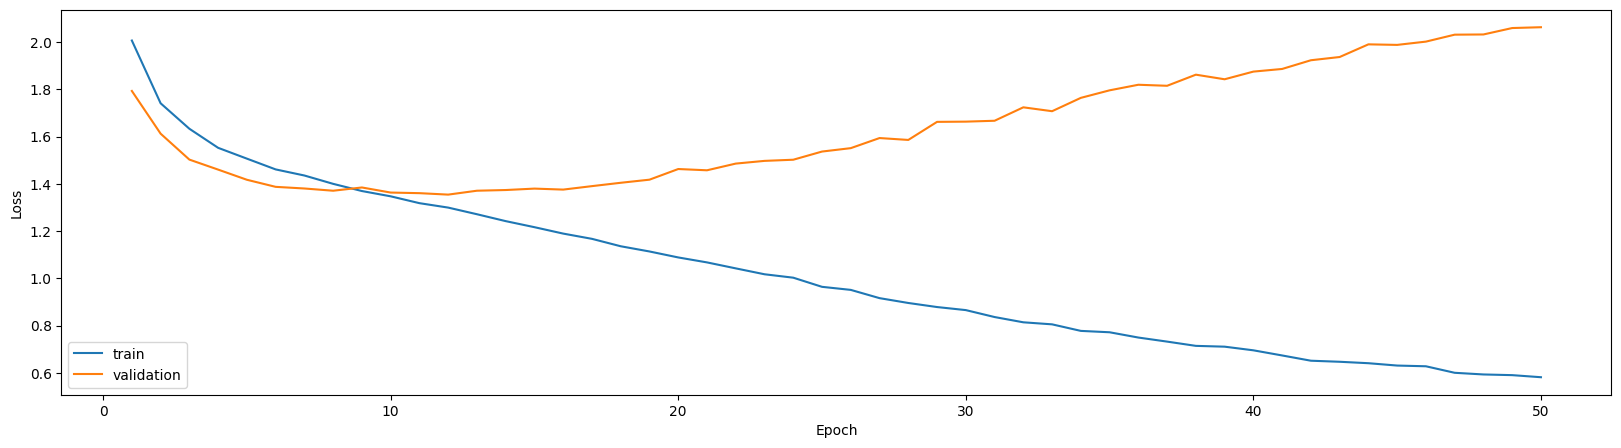

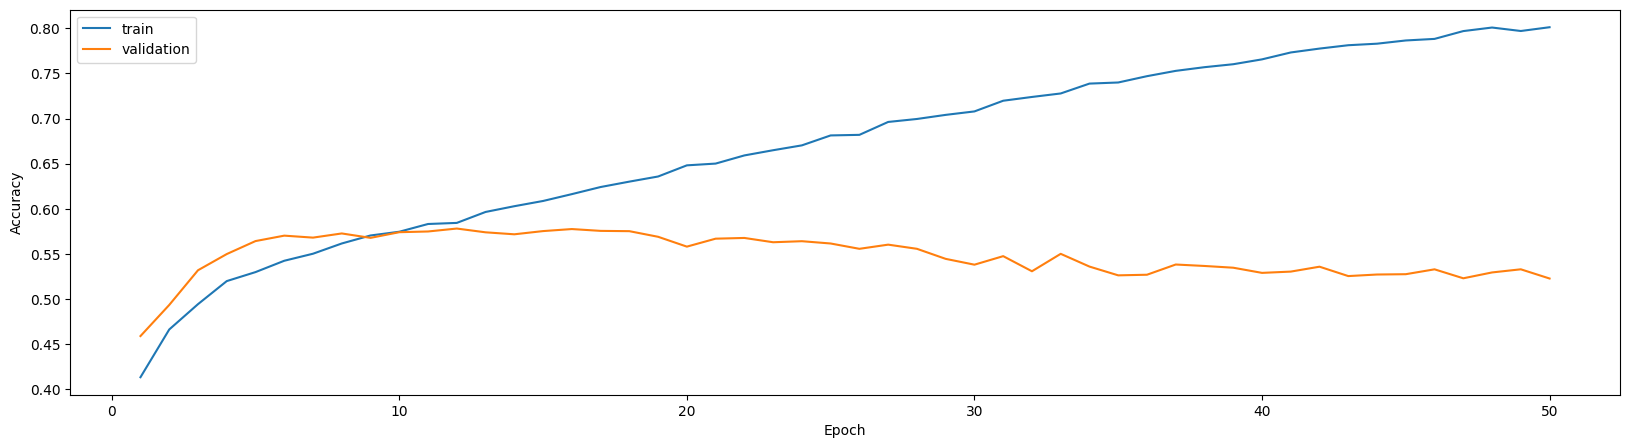

	Evaluation: 100%|██████████| 193/193 [00:02<00:00, 65.99it/s]



Test Loss: 1.346 | Test Acc: 58.12% | Test F1: 0.549 | Test ROC AUC: 0.865

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.82      0.68      4964
           1       0.70      0.57      0.63       640
           2       0.57      0.30      0.39      1070
           3       0.54      0.34      0.42       696
           4       0.40      0.17      0.24       911
           5       0.55      0.41      0.47       135
           6       0.45      0.19      0.26       329
           7       0.45      0.58      0.51       577
           8       0.67      0.44      0.54       180
           9       0.74      0.75      0.74       640
          10       0.35      0.08      0.13       573
          11       0.65      0.51      0.57       225
          12       0.70      0.76      0.73       787
          13       0.59      0.39      0.47       613

    accuracy                           0.58     12340
   macro avg       0.57      0.45 

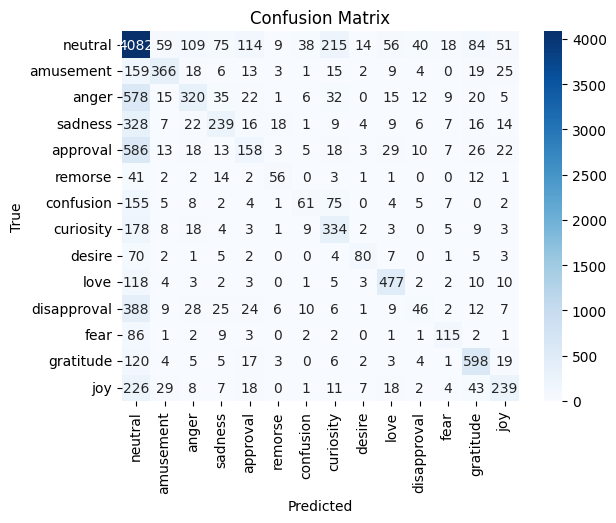

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('RNN2-model.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---

## 2.C. RNN3

In [ ]:
import torch.nn as nn
from torch import optim

# Define a multi-layer RNN
class RNN3(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers = 3, batch_first=True) # added num_layers argument
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        output, hidden = self.rnn(embedded)
        return self.fc(hidden[-1]) # return the hidden state of the last layer only
        # return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256 # changed to 512 from 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes
PAD_IDX = text_vocab["<pad>"]

model = RNN3(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings, PAD_IDX) # create an RNN model using the arguments
print("Model Summary:")
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)


Model Summary:
RNN3(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): RNN(100, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=14, bias=True)
)
The model has 358,414 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN3-model.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.66it/s]


	Train Loss: 2.103 | Train Acc: 39.68%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 79.58it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.991 |  Val. Acc: 42.05%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.31it/s]


	Train Loss: 1.965 | Train Acc: 41.75%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 117.94it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.927 |  Val. Acc: 43.60%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.08it/s]


	Train Loss: 1.939 | Train Acc: 42.38%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 118.00it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.968 |  Val. Acc: 41.61%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:05<00:00, 52.73it/s]


	Train Loss: 1.927 | Train Acc: 43.17%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 110.21it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.964 |  Val. Acc: 43.21%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.80it/s]


	Train Loss: 1.917 | Train Acc: 43.16%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 121.67it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.907 |  Val. Acc: 44.29%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.29it/s]


	Train Loss: 1.898 | Train Acc: 43.58%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 67.04it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.835 |  Val. Acc: 46.35%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:05<00:00, 55.30it/s]


	Train Loss: 1.910 | Train Acc: 43.33%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 117.94it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.917 |  Val. Acc: 41.85%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.95it/s]


	Train Loss: 1.911 | Train Acc: 43.23%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 125.24it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.909 |  Val. Acc: 43.04%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.56it/s]


	Train Loss: 1.887 | Train Acc: 44.13%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 79.26it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.848 |  Val. Acc: 43.33%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.15it/s]


	Train Loss: 1.891 | Train Acc: 44.42%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 123.64it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.917 |  Val. Acc: 43.24%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.01it/s]


	Train Loss: 1.919 | Train Acc: 43.21%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 106.66it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.870 |  Val. Acc: 43.86%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:05<00:00, 56.96it/s]


	Train Loss: 1.906 | Train Acc: 43.11%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 122.52it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.924 |  Val. Acc: 43.25%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.39it/s]


	Train Loss: 1.857 | Train Acc: 44.53%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 119.33it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.904 |  Val. Acc: 40.99%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.05it/s]


	Train Loss: 1.894 | Train Acc: 43.82%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 77.15it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.938 |  Val. Acc: 42.90%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:06<00:00, 51.26it/s]


	Train Loss: 1.871 | Train Acc: 44.57%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 113.41it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.834 |  Val. Acc: 44.48%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:07<00:00, 43.82it/s]


	Train Loss: 1.819 | Train Acc: 45.39%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.82it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.226 |  Val. Acc: 40.38%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.66it/s]


	Train Loss: 2.041 | Train Acc: 41.26%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 121.00it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.976 |  Val. Acc: 43.04%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:03<00:00, 81.24it/s]


	Train Loss: 1.986 | Train Acc: 41.59%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.87it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.972 |  Val. Acc: 41.50%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.43it/s]


	Train Loss: 1.931 | Train Acc: 42.52%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 126.06it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.904 |  Val. Acc: 42.90%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.30it/s]


	Train Loss: 1.880 | Train Acc: 43.85%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 121.88it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.828 |  Val. Acc: 46.72%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.61it/s]


	Train Loss: 1.811 | Train Acc: 45.59%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 78.09it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.837 |  Val. Acc: 44.08%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.59it/s]


	Train Loss: 1.778 | Train Acc: 46.38%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 122.93it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.761 |  Val. Acc: 47.65%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.03it/s]


	Train Loss: 1.844 | Train Acc: 44.87%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 109.87it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.806 |  Val. Acc: 46.03%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:07<00:00, 44.05it/s]


	Train Loss: 1.786 | Train Acc: 46.03%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 77.69it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.758 |  Val. Acc: 47.55%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.67it/s]


	Train Loss: 1.771 | Train Acc: 46.67%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 122.15it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.799 |  Val. Acc: 45.69%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.19it/s]


	Train Loss: 1.754 | Train Acc: 47.27%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 81.06it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.746 |  Val. Acc: 48.29%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.80it/s]


	Train Loss: 1.715 | Train Acc: 47.82%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 124.21it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.716 |  Val. Acc: 48.38%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:03<00:00, 80.17it/s]


	Train Loss: 1.716 | Train Acc: 48.27%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 124.23it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.728 |  Val. Acc: 49.19%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.75it/s]


	Train Loss: 1.751 | Train Acc: 46.78%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 76.43it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.703 |  Val. Acc: 48.78%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.92it/s]


	Train Loss: 1.784 | Train Acc: 46.49%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 120.93it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.842 |  Val. Acc: 47.06%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.81it/s]


	Train Loss: 1.745 | Train Acc: 47.87%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 80.98it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.759 |  Val. Acc: 48.18%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:05<00:00, 53.54it/s]


	Train Loss: 1.751 | Train Acc: 47.87%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 79.11it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.804 |  Val. Acc: 47.81%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:04<00:00, 66.97it/s]


	Train Loss: 1.751 | Train Acc: 47.94%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 124.98it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.796 |  Val. Acc: 48.10%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:05<00:00, 54.24it/s]


	Train Loss: 1.754 | Train Acc: 47.53%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 118.93it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.801 |  Val. Acc: 47.26%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.83it/s]


	Train Loss: 1.716 | Train Acc: 48.05%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 123.98it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.706 |  Val. Acc: 49.87%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.52it/s]


	Train Loss: 1.709 | Train Acc: 48.80%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 80.37it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.699 |  Val. Acc: 49.66%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.31it/s]


	Train Loss: 1.682 | Train Acc: 49.22%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 124.60it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.806 |  Val. Acc: 47.29%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.66it/s]


	Train Loss: 1.727 | Train Acc: 48.05%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 123.37it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.753 |  Val. Acc: 47.57%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:05<00:00, 54.48it/s]


	Train Loss: 1.731 | Train Acc: 48.04%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 121.03it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.741 |  Val. Acc: 48.32%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.22it/s]


	Train Loss: 1.721 | Train Acc: 48.54%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 122.65it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.734 |  Val. Acc: 47.87%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.81it/s]


	Train Loss: 1.774 | Train Acc: 46.48%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 63.11it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.779 |  Val. Acc: 46.71%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:06<00:00, 46.35it/s]


	Train Loss: 1.750 | Train Acc: 46.78%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 122.43it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.766 |  Val. Acc: 46.48%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.10it/s]


	Train Loss: 1.734 | Train Acc: 48.05%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 120.56it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.816 |  Val. Acc: 46.34%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.44it/s]


	Train Loss: 1.748 | Train Acc: 47.11%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 82.38it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.892 |  Val. Acc: 42.29%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.03it/s]


	Train Loss: 1.801 | Train Acc: 45.91%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 123.62it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.822 |  Val. Acc: 47.15%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:03<00:00, 78.86it/s]


	Train Loss: 1.870 | Train Acc: 44.79%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 125.16it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.996 |  Val. Acc: 42.56%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:05<00:00, 54.74it/s]


	Train Loss: 1.826 | Train Acc: 45.59%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 117.54it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.818 |  Val. Acc: 47.45%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:03<00:00, 80.47it/s]


	Train Loss: 1.736 | Train Acc: 48.16%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 123.82it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.811 |  Val. Acc: 46.79%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.85it/s]


	Train Loss: 1.771 | Train Acc: 46.91%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 81.38it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.757 |  Val. Acc: 49.05%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.84it/s]


	Train Loss: 1.717 | Train Acc: 48.93%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 80.75it/s]


	 Val. Loss: 1.788 |  Val. Acc: 47.37%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


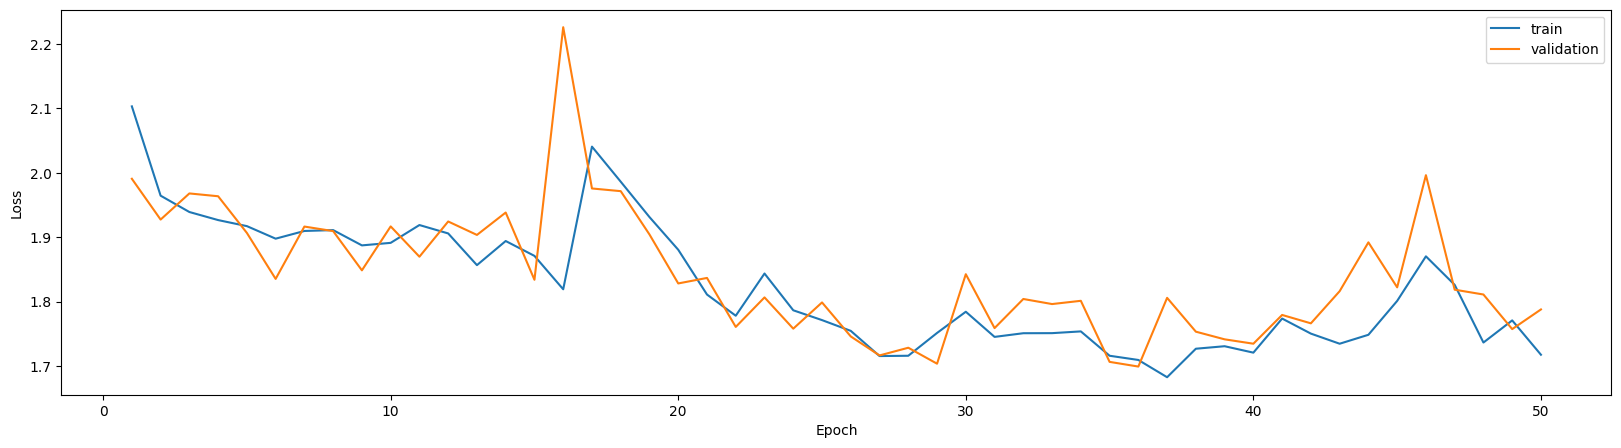

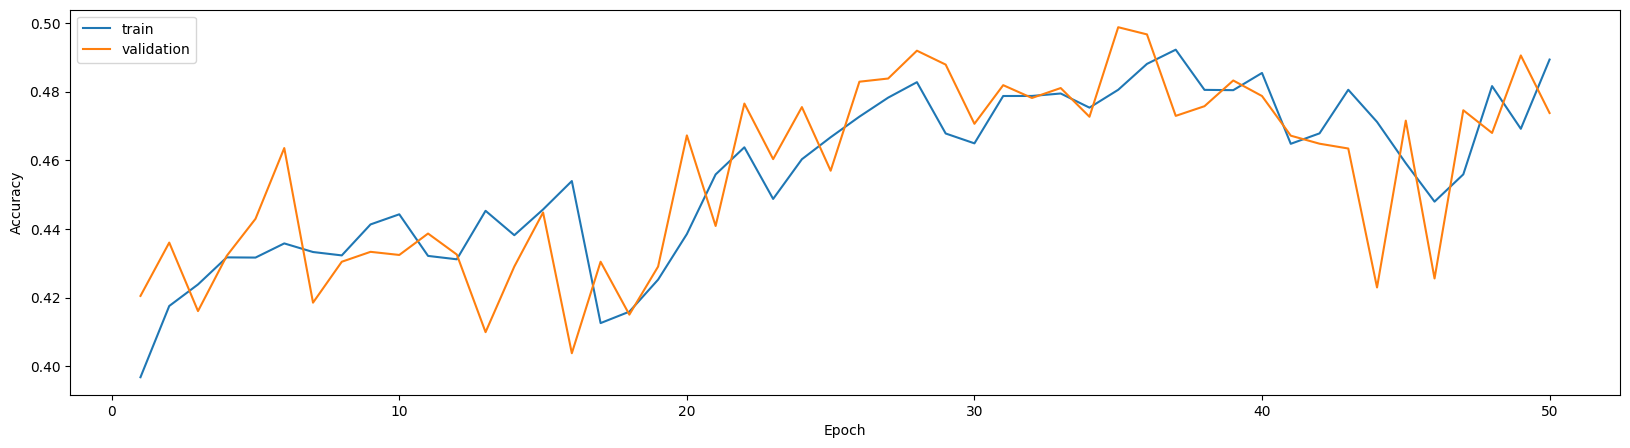

	Evaluation: 100%|██████████| 193/193 [00:05<00:00, 35.29it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Loss: 1.680 | Test Acc: 50.20% | Test F1: 0.425 | Test ROC AUC: 0.778

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.87      0.64      4983
           1       0.59      0.41      0.49       672
           2       0.40      0.22      0.28      1070
           3       0.33      0.15      0.20       667
           4       0.21      0.01      0.01       837
           5       0.33      0.10      0.15       144
           6       0.00      0.00      0.00       351
           7       0.39      0.41      0.40       551
           8       0.00      0.00      0.00       200
           9       0.60      0.63      0.61       614
          10       0.00      0.00      0.00       570
          11       0.00      0.00      0.00       208
          12       0.66      0.61      0.63       844
          13       0.34      0.16      0.22       629

    accuracy                           0.50     12340
   macro avg       0.31      0.25 

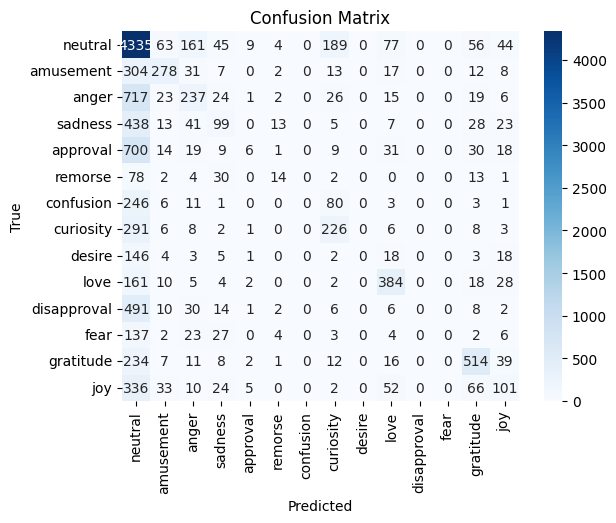

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('RNN3-model.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---

## 2.D. RNN4

In [ ]:
import torch.nn as nn
from torch import optim

# Define a bidirectional RNN
class RNN4(nn.Module):
    def __init__(self, pretrained_embeddings, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        self.rnn = nn.LSTM(pretrained_embeddings.shape[1],
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))                   # VV note that lengths need to be on the CPU
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        if self.num_directions == 2:  # if bidirectional
            # Concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers and apply dropout
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

# Setting model building arguments
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab)
N_LAYERS = 4
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = text_vocab["<pad>"]

model = RNN4(pretrained_embeddings, HIDDEN_DIM,  OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX) # create a RNN model using the arguments
print("Model Summary:")
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters')


# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

Model Summary:
RNN4(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=4, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=14, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 5,471,246 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN4-model.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:10<00:00, 30.68it/s]


	Train Loss: 2.071 | Train Acc: 40.50%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.45it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.877 |  Val. Acc: 43.61%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:08<00:00, 35.64it/s]


	Train Loss: 1.859 | Train Acc: 44.21%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 58.35it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.719 |  Val. Acc: 48.04%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:10<00:00, 29.95it/s]


	Train Loss: 1.728 | Train Acc: 47.66%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.51it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.582 |  Val. Acc: 52.70%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:09<00:00, 32.03it/s]


	Train Loss: 1.647 | Train Acc: 49.86%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 91.41it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.503 |  Val. Acc: 53.84%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:09<00:00, 32.00it/s]


	Train Loss: 1.581 | Train Acc: 51.79%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.20it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.450 |  Val. Acc: 55.78%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:08<00:00, 37.00it/s]


	Train Loss: 1.526 | Train Acc: 52.45%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 58.79it/s]


	 Val. Loss: 1.441 |  Val. Acc: 56.42%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:10<00:00, 30.56it/s]


	Train Loss: 1.488 | Train Acc: 53.63%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 76.54it/s]


	 Val. Loss: 1.383 |  Val. Acc: 57.60%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:09<00:00, 31.82it/s]


	Train Loss: 1.456 | Train Acc: 54.60%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.37it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.382 |  Val. Acc: 57.32%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:10<00:00, 29.55it/s]


	Train Loss: 1.438 | Train Acc: 55.19%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.79it/s]


	 Val. Loss: 1.371 |  Val. Acc: 57.45%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:09<00:00, 34.54it/s]


	Train Loss: 1.404 | Train Acc: 56.13%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 59.72it/s]


	 Val. Loss: 1.356 |  Val. Acc: 58.68%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:09<00:00, 34.56it/s]


	Train Loss: 1.384 | Train Acc: 57.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.74it/s]


	 Val. Loss: 1.353 |  Val. Acc: 58.35%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:12<00:00, 26.08it/s]


	Train Loss: 1.363 | Train Acc: 56.90%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.94it/s]


	 Val. Loss: 1.356 |  Val. Acc: 57.70%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:10<00:00, 31.05it/s]


	Train Loss: 1.348 | Train Acc: 57.34%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.53it/s]


	 Val. Loss: 1.355 |  Val. Acc: 58.42%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:08<00:00, 37.65it/s]


	Train Loss: 1.320 | Train Acc: 57.97%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 61.56it/s]


	 Val. Loss: 1.344 |  Val. Acc: 58.99%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:09<00:00, 34.29it/s]


	Train Loss: 1.309 | Train Acc: 58.32%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 91.12it/s]


	 Val. Loss: 1.323 |  Val. Acc: 59.37%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:11<00:00, 28.56it/s]


	Train Loss: 1.283 | Train Acc: 59.09%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 65.90it/s]


	 Val. Loss: 1.351 |  Val. Acc: 59.05%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:09<00:00, 32.29it/s]


	Train Loss: 1.266 | Train Acc: 59.42%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.00it/s]


	 Val. Loss: 1.346 |  Val. Acc: 57.99%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:08<00:00, 37.56it/s]


	Train Loss: 1.248 | Train Acc: 60.06%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 61.88it/s]


	 Val. Loss: 1.358 |  Val. Acc: 57.85%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:09<00:00, 34.13it/s]


	Train Loss: 1.225 | Train Acc: 60.71%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.80it/s]


	 Val. Loss: 1.363 |  Val. Acc: 59.02%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:09<00:00, 31.73it/s]


	Train Loss: 1.210 | Train Acc: 61.05%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.98it/s]


	 Val. Loss: 1.351 |  Val. Acc: 58.85%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:11<00:00, 27.14it/s]


	Train Loss: 1.181 | Train Acc: 61.87%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 72.34it/s]


	 Val. Loss: 1.365 |  Val. Acc: 58.50%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:08<00:00, 37.50it/s]


	Train Loss: 1.182 | Train Acc: 61.98%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 70.58it/s]


	 Val. Loss: 1.346 |  Val. Acc: 58.79%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:09<00:00, 33.59it/s]


	Train Loss: 1.153 | Train Acc: 62.61%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.69it/s]


	 Val. Loss: 1.367 |  Val. Acc: 58.50%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:09<00:00, 31.57it/s]


	Train Loss: 1.142 | Train Acc: 62.84%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.29it/s]


	 Val. Loss: 1.374 |  Val. Acc: 58.69%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:09<00:00, 34.38it/s]


	Train Loss: 1.117 | Train Acc: 63.46%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 46.50it/s]


	 Val. Loss: 1.411 |  Val. Acc: 58.44%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:09<00:00, 32.01it/s]


	Train Loss: 1.107 | Train Acc: 63.86%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.31it/s]


	 Val. Loss: 1.403 |  Val. Acc: 57.82%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:09<00:00, 31.70it/s]


	Train Loss: 1.086 | Train Acc: 64.31%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.70it/s]


	 Val. Loss: 1.393 |  Val. Acc: 58.20%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:09<00:00, 31.75it/s]


	Train Loss: 1.072 | Train Acc: 64.95%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.34it/s]


	 Val. Loss: 1.424 |  Val. Acc: 57.61%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:08<00:00, 35.99it/s]


	Train Loss: 1.054 | Train Acc: 65.24%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 62.60it/s]


	 Val. Loss: 1.438 |  Val. Acc: 57.93%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:10<00:00, 30.29it/s]


	Train Loss: 1.029 | Train Acc: 66.29%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.14it/s]


	 Val. Loss: 1.460 |  Val. Acc: 57.23%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:09<00:00, 31.65it/s]


	Train Loss: 1.009 | Train Acc: 66.56%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.89it/s]


	 Val. Loss: 1.478 |  Val. Acc: 56.56%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:09<00:00, 31.57it/s]


	Train Loss: 1.002 | Train Acc: 66.72%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.03it/s]


	 Val. Loss: 1.468 |  Val. Acc: 57.34%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:08<00:00, 35.89it/s]


	Train Loss: 0.993 | Train Acc: 67.46%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 61.51it/s]


	 Val. Loss: 1.500 |  Val. Acc: 56.79%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:08<00:00, 35.73it/s]


	Train Loss: 0.977 | Train Acc: 67.39%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.69it/s]


	 Val. Loss: 1.487 |  Val. Acc: 56.73%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:12<00:00, 26.19it/s]


	Train Loss: 0.950 | Train Acc: 68.46%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.66it/s]


	 Val. Loss: 1.519 |  Val. Acc: 57.03%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:09<00:00, 34.15it/s]


	Train Loss: 0.948 | Train Acc: 68.54%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 58.44it/s]


	 Val. Loss: 1.550 |  Val. Acc: 56.90%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:08<00:00, 37.43it/s]


	Train Loss: 0.939 | Train Acc: 68.66%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.42it/s]


	 Val. Loss: 1.567 |  Val. Acc: 55.43%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:09<00:00, 32.24it/s]


	Train Loss: 0.918 | Train Acc: 69.35%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.42it/s]


	 Val. Loss: 1.538 |  Val. Acc: 56.34%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:11<00:00, 27.96it/s]


	Train Loss: 0.886 | Train Acc: 70.23%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 60.86it/s]


	 Val. Loss: 1.585 |  Val. Acc: 55.38%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:09<00:00, 34.82it/s]


	Train Loss: 0.883 | Train Acc: 70.16%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 60.69it/s]


	 Val. Loss: 1.607 |  Val. Acc: 55.43%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:08<00:00, 36.37it/s]


	Train Loss: 0.882 | Train Acc: 70.38%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.26it/s]


	 Val. Loss: 1.606 |  Val. Acc: 56.61%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:10<00:00, 30.63it/s]


	Train Loss: 0.846 | Train Acc: 71.43%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.62it/s]


	 Val. Loss: 1.658 |  Val. Acc: 54.64%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:10<00:00, 31.14it/s]


	Train Loss: 0.847 | Train Acc: 71.88%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.35it/s]


	 Val. Loss: 1.660 |  Val. Acc: 55.21%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:11<00:00, 28.51it/s]


	Train Loss: 0.820 | Train Acc: 72.39%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 59.76it/s]


	 Val. Loss: 1.661 |  Val. Acc: 55.93%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:08<00:00, 37.06it/s]


	Train Loss: 0.826 | Train Acc: 72.24%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 79.07it/s]


	 Val. Loss: 1.710 |  Val. Acc: 54.02%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:09<00:00, 32.48it/s]


	Train Loss: 0.811 | Train Acc: 72.64%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.82it/s]


	 Val. Loss: 1.689 |  Val. Acc: 55.00%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:10<00:00, 31.41it/s]


	Train Loss: 0.796 | Train Acc: 73.32%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.11it/s]


	 Val. Loss: 1.682 |  Val. Acc: 55.18%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:09<00:00, 33.99it/s]


	Train Loss: 0.795 | Train Acc: 73.12%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 53.86it/s]


	 Val. Loss: 1.731 |  Val. Acc: 53.61%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:10<00:00, 30.83it/s]


	Train Loss: 0.778 | Train Acc: 73.82%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.45it/s]


	 Val. Loss: 1.713 |  Val. Acc: 54.87%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:10<00:00, 30.90it/s]


	Train Loss: 0.749 | Train Acc: 74.70%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.70it/s]


	 Val. Loss: 1.767 |  Val. Acc: 53.87%


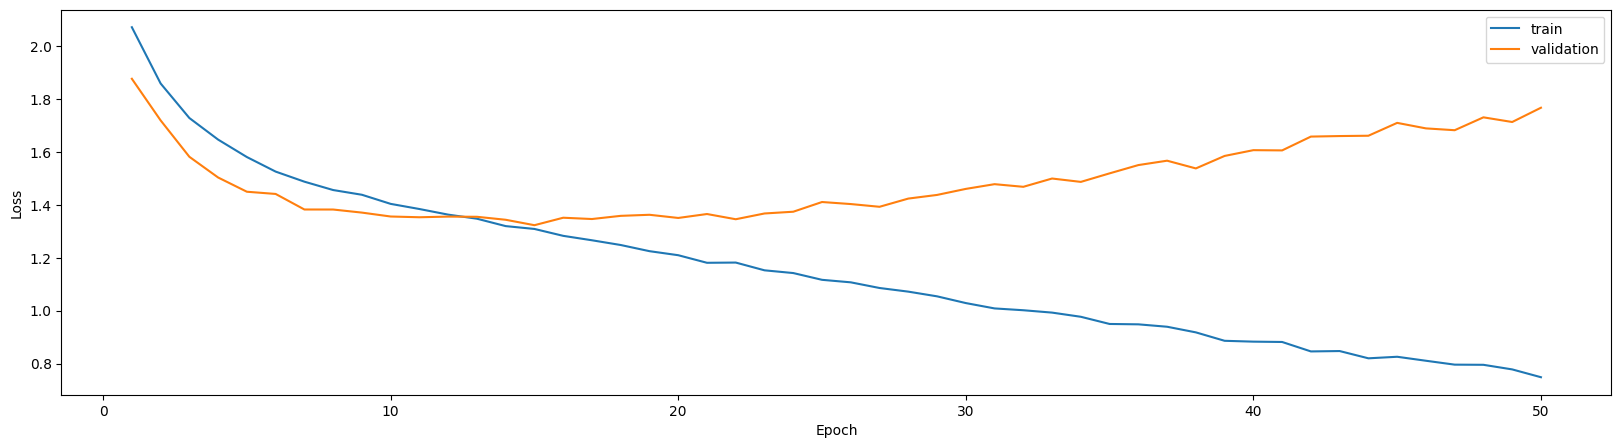

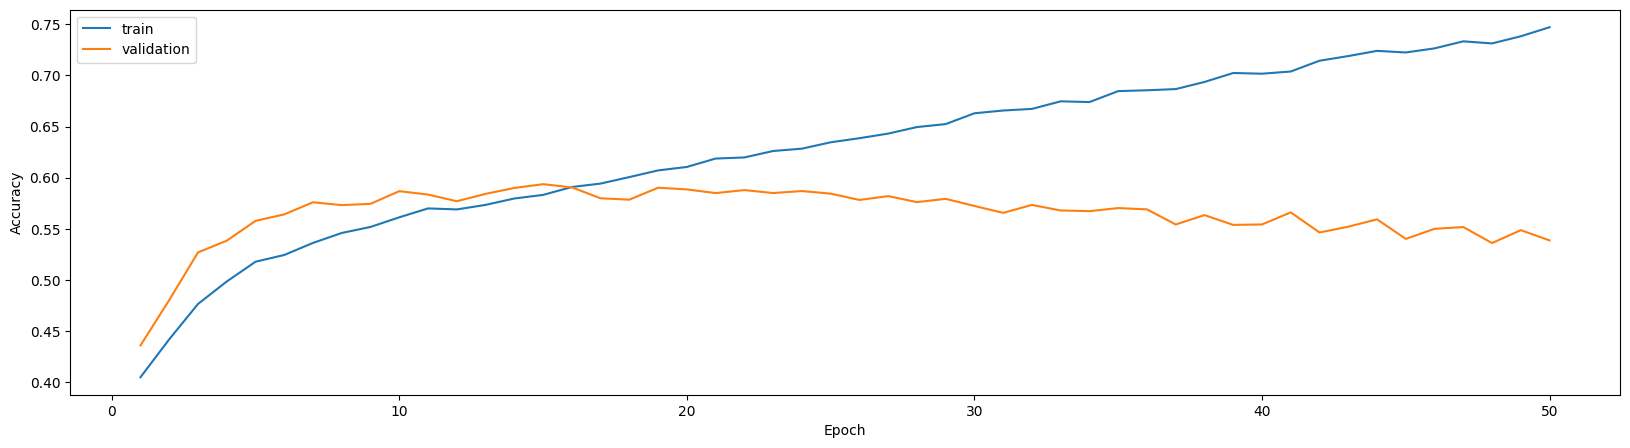

	Evaluation: 100%|██████████| 193/193 [00:02<00:00, 81.84it/s]



Test Loss: 1.323 | Test Acc: 59.07% | Test F1: 0.560 | Test ROC AUC: 0.868

Classification report:
              precision    recall  f1-score   support

           0       0.59      0.81      0.68      4983
           1       0.65      0.60      0.62       672
           2       0.51      0.41      0.46      1070
           3       0.59      0.34      0.43       667
           4       0.47      0.12      0.19       837
           5       0.60      0.30      0.40       144
           6       0.43      0.27      0.33       351
           7       0.43      0.61      0.50       551
           8       0.72      0.32      0.44       200
           9       0.69      0.78      0.73       614
          10       0.37      0.09      0.14       570
          11       0.64      0.54      0.59       208
          12       0.81      0.73      0.77       844
          13       0.62      0.42      0.50       629

    accuracy                           0.59     12340
   macro avg       0.58      0.45 

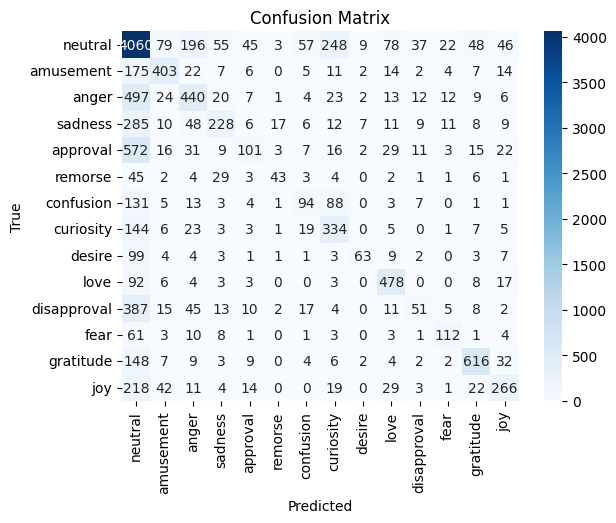

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('RNN4-model.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---

## Results

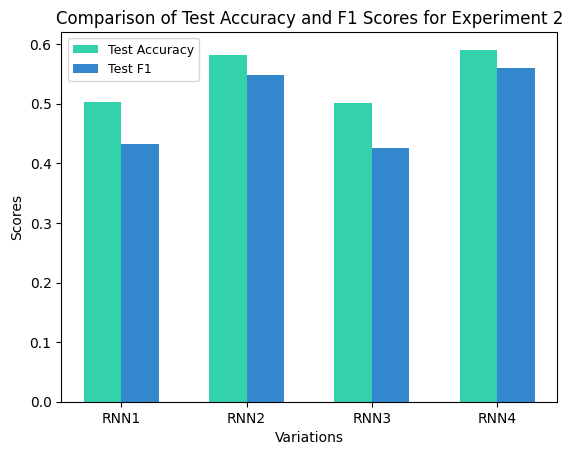

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

variations = ['RNN1', 'RNN2', 'RNN3', 'RNN4']
test_accuracy_list = [0.5022, 0.5812, 0.5020, 0.5907]
test_f1_list = [0.433, 0.548, 0.425, 0.56]

fig, ax = plt.subplots()

# Create x-axis values so it can be used for any number of variations
x_values = np.arange(len(variations))

# Plot the bar charts
rects1 = ax.bar(x_values, test_accuracy_list, 0.3, alpha=0.8, color='#00c698', label='Test Accuracy')
rects2 = ax.bar(x_values + 0.3, test_f1_list, 0.3, alpha=0.8, color='#0069c0', label='Test F1')

# Add labels and titles
ax.set_xlabel('Variations')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Test Accuracy and F1 Scores for Experiment 2')
ax.set_xticks(x_values + 0.3 / 2)
ax.set_xticklabels(variations)
ax.legend(loc='upper left', fontsize=9)

# Show the plot
plt.show()




---





---



---

## Conclusion



---
---
---

